# v10 Training: Large-Scale Cross-Lingual Neural Sparse Model

10M+ 대규모 데이터셋으로 학습하는 cross-lingual 모델입니다.

## v10 특징
- **대규모 데이터**: 10M+ KO-EN 병렬 쌍
- **개선된 Loss**: v9 기반 + 대규모 최적화
- **효율적 학습**: Gradient accumulation, Mixed precision

## 1. Setup

In [1]:
import sys
import json
from pathlib import Path

def find_project_root():
    candidates = [
        Path.cwd(),
        Path.cwd().parent,
        Path.cwd().parent.parent,
        Path("/home/west/Documents/cursor-workspace/opensearch-neural-pre-train"),
    ]
    for candidate in candidates:
        if (candidate / "CLAUDE.md").exists() or (candidate / ".git").exists():
            return candidate
    return Path("/home/west/Documents/cursor-workspace/opensearch-neural-pre-train")

PROJECT_ROOT = find_project_root()
sys.path.insert(0, str(PROJECT_ROOT))

print(f"Project root: {PROJECT_ROOT}")

Project root: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train


In [2]:
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, IterableDataset
from torch.cuda.amp import autocast, GradScaler
from transformers import AutoTokenizer, get_linear_schedule_with_warmup
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from src.model.splade_model import create_splade_model

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

PyTorch: 2.10.0.dev20251109+cu130
CUDA available: True
Using device: cuda
GPU: NVIDIA GB10
GPU Memory: 128.5 GB


/home/west/Documents/cursor-workspace/opensearch-neural-pre-train/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:435: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)
    
  queued_call()


## 2. Configuration

In [3]:
CONFIG = {
    # Model
    'model_name': 'bert-base-multilingual-cased',
    'max_length': 64,
    
    # Data
    'data_dir': PROJECT_ROOT / 'dataset' / 'v10_large_scale',
    
    # Training
    'batch_size': 128,           # Larger batch for large dataset
    'gradient_accumulation': 4,  # Effective batch = 512
    'num_epochs': 3,             # Fewer epochs for large data
    'learning_rate': 5e-5,       # Slightly higher LR
    'warmup_ratio': 0.05,
    'max_grad_norm': 1.0,
    'use_amp': True,             # Mixed precision training
    
    # Loss weights (v9 optimized)
    'lambda_self': 0.3,
    'lambda_target': 2.0,
    'lambda_margin': 1.0,
    'lambda_negative': 0.5,
    'lambda_sparsity': 0.01,
    
    # Margin
    'target_margin': 1.5,
    
    # Logging
    'log_interval': 1000,
    'eval_interval': 10000,
    'save_interval': 50000,
    
    # Output
    'output_dir': PROJECT_ROOT / 'outputs' / 'v10_large_scale',
}

print("v10 Configuration:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")

v10 Configuration:
  model_name: bert-base-multilingual-cased
  max_length: 64
  data_dir: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/dataset/v10_large_scale
  batch_size: 128
  gradient_accumulation: 4
  num_epochs: 3
  learning_rate: 5e-05
  warmup_ratio: 0.05
  max_grad_norm: 1.0
  use_amp: True
  lambda_self: 0.3
  lambda_target: 2.0
  lambda_margin: 1.0
  lambda_negative: 0.5
  lambda_sparsity: 0.01
  target_margin: 1.5
  log_interval: 1000
  eval_interval: 10000
  save_interval: 50000
  output_dir: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v10_large_scale


## 3. Non-Target Language Token Detection

In [4]:
def is_non_target_token(token: str) -> bool:
    """Check if token is from non-target language."""
    clean = token.replace('##', '')
    if not clean:
        return False
    
    has_korean = any('\uac00' <= c <= '\ud7a3' for c in clean)
    has_english = any(c.isalpha() and c.isascii() for c in clean)
    
    if has_korean or has_english:
        return False
    
    has_japanese = any('\u3040' <= c <= '\u309f' or '\u30a0' <= c <= '\u30ff' for c in clean)
    has_cjk = any('\u4e00' <= c <= '\u9fff' for c in clean)
    has_cyrillic = any('\u0400' <= c <= '\u04ff' for c in clean)
    has_arabic = any('\u0600' <= c <= '\u06ff' for c in clean)
    has_thai = any('\u0e00' <= c <= '\u0e7f' for c in clean)
    
    return has_japanese or has_cjk or has_cyrillic or has_arabic or has_thai

# Build non-target token IDs
tokenizer = AutoTokenizer.from_pretrained(CONFIG['model_name'])

print("Building non-target language token ID list...")
non_target_ids = []
for token_id in tqdm(range(tokenizer.vocab_size)):
    token = tokenizer.convert_ids_to_tokens(token_id)
    if is_non_target_token(token):
        non_target_ids.append(token_id)

non_target_ids_tensor = torch.tensor(non_target_ids, dtype=torch.long)
print(f"Found {len(non_target_ids):,} non-target language tokens")

Building non-target language token ID list...


  0%|          | 0/119547 [00:00<?, ?it/s]

Found 33,896 non-target language tokens


## 4. Dataset

In [5]:
class LargeScaleDataset(Dataset):
    """
    Large-scale KO-EN parallel dataset for v10 training.
    Loads data from JSONL file.
    """
    
    def __init__(self, data_path: Path, tokenizer, max_length: int = 64):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = []
        
        print(f"Loading dataset from {data_path}...")
        
        with open(data_path, 'r', encoding='utf-8') as f:
            for line in tqdm(f, desc="Loading"):
                item = json.loads(line.strip())
                
                ko_term = item['ko_term']
                en_term = item['en_term']
                
                # Pre-tokenize for efficiency
                ko_tokens = tokenizer.tokenize(ko_term)
                ko_token_ids = tokenizer.convert_tokens_to_ids(ko_tokens)
                ko_token_ids = [tid for tid in ko_token_ids if tid != tokenizer.unk_token_id]
                
                en_tokens = tokenizer.tokenize(en_term.lower())
                en_token_ids = tokenizer.convert_tokens_to_ids(en_tokens)
                en_token_ids = [tid for tid in en_token_ids if tid != tokenizer.unk_token_id]
                
                if ko_token_ids and en_token_ids:
                    self.data.append({
                        'ko_term': ko_term,
                        'en_term': en_term,
                        'ko_token_ids': ko_token_ids,
                        'en_token_ids': en_token_ids,
                    })
        
        print(f"Loaded {len(self.data):,} samples")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        
        encoding = self.tokenizer(
            item['ko_term'],
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'ko_token_ids': item['ko_token_ids'],
            'en_token_ids': item['en_token_ids'],
        }


def collate_fn(batch):
    return {
        'input_ids': torch.stack([item['input_ids'] for item in batch]),
        'attention_mask': torch.stack([item['attention_mask'] for item in batch]),
        'ko_token_ids': [item['ko_token_ids'] for item in batch],
        'en_token_ids': [item['en_token_ids'] for item in batch],
    }

In [6]:
# Check if data exists
train_path = CONFIG['data_dir'] / 'train.jsonl'
val_path = CONFIG['data_dir'] / 'val.jsonl'

if not train_path.exists():
    print(f"Training data not found at {train_path}")
    print("Please run 01_data_preparation_large_scale.ipynb first!")
else:
    # Load datasets
    train_dataset = LargeScaleDataset(train_path, tokenizer, CONFIG['max_length'])
    
    if val_path.exists():
        val_dataset = LargeScaleDataset(val_path, tokenizer, CONFIG['max_length'])
    else:
        val_dataset = None
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=True,
        num_workers=4,
        collate_fn=collate_fn,
        pin_memory=True,
        drop_last=True,
    )
    
    print(f"\nTrain dataset: {len(train_dataset):,} samples")
    print(f"Batches per epoch: {len(train_loader):,}")
    print(f"Effective batch size: {CONFIG['batch_size'] * CONFIG['gradient_accumulation']}")

Loading dataset from /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/dataset/v10_large_scale/train.jsonl...


Loading: 0it [00:00, ?it/s]

Loaded 4,633,049 samples
Loading dataset from /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/dataset/v10_large_scale/val.jsonl...


Loading: 0it [00:00, ?it/s]

Loaded 46,792 samples

Train dataset: 4,633,049 samples
Batches per epoch: 36,195
Effective batch size: 512


## 5. Loss Function

In [7]:
class V10CrossLingualLoss(nn.Module):
    """
    v10 Large-Scale Loss: Optimized for large datasets.
    """
    
    def __init__(self, target_margin: float = 1.5, non_target_ids: torch.Tensor = None):
        super().__init__()
        self.target_margin = target_margin
        self.non_target_ids = non_target_ids
    
    def forward(
        self,
        sparse_rep: torch.Tensor,
        ko_token_ids: list,
        en_token_ids: list,
    ) -> dict:
        batch_size = sparse_rep.shape[0]
        device = sparse_rep.device
        
        self_loss = torch.tensor(0.0, device=device)
        target_loss = torch.tensor(0.0, device=device)
        margin_loss = torch.tensor(0.0, device=device)
        negative_loss = torch.tensor(0.0, device=device)
        
        n_valid = 0
        
        for i in range(batch_size):
            rep = sparse_rep[i]
            
            # 1. Self-preservation loss (Korean tokens)
            if ko_token_ids[i]:
                ko_ids = torch.tensor(ko_token_ids[i], device=device)
                ko_activations = rep[ko_ids]
                self_loss = self_loss - torch.log(ko_activations + 1e-8).mean()
            
            # 2. English target loss
            if en_token_ids[i]:
                en_ids = torch.tensor(en_token_ids[i], device=device)
                en_activations = rep[en_ids]
                target_loss = target_loss - torch.log(en_activations + 1e-8).mean()
                margin_loss = margin_loss + F.relu(self.target_margin - en_activations).mean()
            
            # 3. Negative sampling loss
            if self.non_target_ids is not None:
                # Sample subset for efficiency
                sample_size = min(1000, len(self.non_target_ids))
                sample_idx = torch.randperm(len(self.non_target_ids))[:sample_size]
                sampled_ids = self.non_target_ids[sample_idx].to(device)
                non_target_activations = rep[sampled_ids]
                negative_loss = negative_loss + F.relu(non_target_activations - 0.1).mean()
            
            n_valid += 1
        
        if n_valid > 0:
            self_loss = self_loss / n_valid
            target_loss = target_loss / n_valid
            margin_loss = margin_loss / n_valid
            negative_loss = negative_loss / n_valid
        
        return {
            'self': self_loss,
            'target': target_loss,
            'margin': margin_loss,
            'negative': negative_loss,
        }

## 6. Model Setup

In [8]:
# Create model
model = create_splade_model(
    model_name=CONFIG['model_name'],
    use_idf=False,
    use_expansion=True,
    expansion_mode='mlm',
)
model = model.to(device)

print(f"Model: {CONFIG['model_name']}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model: bert-base-multilingual-cased
Parameters: 177,974,523


In [9]:
# Loss, optimizer, scheduler
loss_fn = V10CrossLingualLoss(
    target_margin=CONFIG['target_margin'],
    non_target_ids=non_target_ids_tensor
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=0.01
)

total_steps = len(train_loader) * CONFIG['num_epochs'] // CONFIG['gradient_accumulation']
warmup_steps = int(total_steps * CONFIG['warmup_ratio'])

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Mixed precision scaler
scaler = GradScaler() if CONFIG['use_amp'] else None

print(f"Total steps: {total_steps:,}")
print(f"Warmup steps: {warmup_steps:,}")
print(f"Mixed precision: {CONFIG['use_amp']}")

Total steps: 27,146
Warmup steps: 1,357
Mixed precision: True


/tmp/ipykernel_1511630/2026188513.py:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if CONFIG['use_amp'] else None


## 7. Evaluation

In [10]:
TEST_PAIRS = [
    ("머신러닝", ["machine", "learning"]),
    ("딥러닝", ["deep", "learning"]),
    ("자연어처리", ["natural", "language", "processing"]),
    ("인공지능", ["artificial", "intelligence"]),
    ("데이터", ["data"]),
    ("컴퓨터", ["computer"]),
    ("네트워크", ["network"]),
    ("알고리즘", ["algorithm"]),
    ("프로그래밍", ["programming"]),
    ("소프트웨어", ["software"]),
]


def evaluate_model(model, tokenizer, device, top_k=50):
    """Quick evaluation on test pairs."""
    model.eval()
    
    ko_activated_total = 0
    en_activated_total = 0
    ko_expected_total = 0
    en_expected_total = 0
    non_target_total = 0
    
    with torch.no_grad():
        for ko_term, en_expected in TEST_PAIRS:
            encoding = tokenizer(
                ko_term,
                max_length=64,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            
            sparse_rep, _ = model(
                encoding['input_ids'].to(device),
                encoding['attention_mask'].to(device)
            )
            
            sparse_rep = sparse_rep[0].cpu()
            top_indices = torch.topk(sparse_rep, k=top_k).indices.tolist()
            top_tokens = set(tokenizer.convert_ids_to_tokens(top_indices))
            
            # Korean preservation
            ko_input_tokens = set(tokenizer.tokenize(ko_term))
            for tok in ko_input_tokens:
                ko_expected_total += 1
                if tok in top_tokens:
                    ko_activated_total += 1
            
            # English activation
            for en in en_expected:
                en_toks = tokenizer.tokenize(en.lower())
                for tok in en_toks:
                    en_expected_total += 1
                    if tok in top_tokens:
                        en_activated_total += 1
            
            # Non-target count
            for idx in top_indices:
                tok = tokenizer.convert_ids_to_tokens(idx)
                if is_non_target_token(tok):
                    non_target_total += 1
    
    model.train()
    
    return {
        'ko_rate': ko_activated_total / ko_expected_total * 100 if ko_expected_total > 0 else 0,
        'en_rate': en_activated_total / en_expected_total * 100 if en_expected_total > 0 else 0,
        'avg_non_target': non_target_total / len(TEST_PAIRS),
    }

In [11]:
# Initial evaluation
print("Initial evaluation (before training):")
init_eval = evaluate_model(model, tokenizer, device)
print(f"  Korean preservation: {init_eval['ko_rate']:.1f}%")
print(f"  English activation: {init_eval['en_rate']:.1f}%")
print(f"  Avg non-target: {init_eval['avg_non_target']:.1f}")

Initial evaluation (before training):
  Korean preservation: 100.0%
  English activation: 0.0%
  Avg non-target: 18.7


## 8. Training Loop

In [12]:
# Create output directory
CONFIG['output_dir'].mkdir(parents=True, exist_ok=True)

# Training history
history = []

print("=" * 70)
print("STARTING v10 LARGE-SCALE TRAINING")
print(f"Dataset: {len(train_dataset):,} samples")
print(f"Epochs: {CONFIG['num_epochs']}")
print(f"Batch size: {CONFIG['batch_size']} x {CONFIG['gradient_accumulation']} = {CONFIG['batch_size'] * CONFIG['gradient_accumulation']}")
print("=" * 70)

STARTING v10 LARGE-SCALE TRAINING
Dataset: 4,633,049 samples
Epochs: 3
Batch size: 128 x 4 = 512


In [13]:
global_step = 0
best_en_rate = 0

for epoch in range(CONFIG['num_epochs']):
    print(f"\n{'='*70}")
    print(f"EPOCH {epoch + 1}/{CONFIG['num_epochs']}")
    print(f"{'='*70}")
    
    model.train()
    epoch_losses = {'total': 0, 'self': 0, 'target': 0, 'margin': 0, 'negative': 0}
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}")
    optimizer.zero_grad()
    
    for batch_idx, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        # Forward pass with mixed precision
        if CONFIG['use_amp']:
            with autocast():
                sparse_rep, _ = model(input_ids, attention_mask)
                losses = loss_fn(sparse_rep, batch['ko_token_ids'], batch['en_token_ids'])
                sparsity_loss = sparse_rep.mean()
                
                total_loss = (
                    CONFIG['lambda_self'] * losses['self'] +
                    CONFIG['lambda_target'] * losses['target'] +
                    CONFIG['lambda_margin'] * losses['margin'] +
                    CONFIG['lambda_negative'] * losses['negative'] +
                    CONFIG['lambda_sparsity'] * sparsity_loss
                ) / CONFIG['gradient_accumulation']
            
            scaler.scale(total_loss).backward()
        else:
            sparse_rep, _ = model(input_ids, attention_mask)
            losses = loss_fn(sparse_rep, batch['ko_token_ids'], batch['en_token_ids'])
            sparsity_loss = sparse_rep.mean()
            
            total_loss = (
                CONFIG['lambda_self'] * losses['self'] +
                CONFIG['lambda_target'] * losses['target'] +
                CONFIG['lambda_margin'] * losses['margin'] +
                CONFIG['lambda_negative'] * losses['negative'] +
                CONFIG['lambda_sparsity'] * sparsity_loss
            ) / CONFIG['gradient_accumulation']
            
            total_loss.backward()
        
        # Accumulate losses
        epoch_losses['total'] += total_loss.item() * CONFIG['gradient_accumulation']
        epoch_losses['self'] += losses['self'].item()
        epoch_losses['target'] += losses['target'].item()
        epoch_losses['margin'] += losses['margin'].item()
        epoch_losses['negative'] += losses['negative'].item()
        
        # Gradient accumulation step
        if (batch_idx + 1) % CONFIG['gradient_accumulation'] == 0:
            if CONFIG['use_amp']:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG['max_grad_norm'])
                scaler.step(optimizer)
                scaler.update()
            else:
                torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG['max_grad_norm'])
                optimizer.step()
            
            scheduler.step()
            optimizer.zero_grad()
            global_step += 1
        
        # Update progress bar
        if (batch_idx + 1) % CONFIG['log_interval'] == 0:
            avg_loss = epoch_losses['total'] / (batch_idx + 1)
            progress_bar.set_postfix({
                'loss': f"{avg_loss:.4f}",
                'tgt': f"{epoch_losses['target']/(batch_idx+1):.4f}",
                'step': global_step,
            })
        
        # Periodic evaluation
        if (batch_idx + 1) % CONFIG['eval_interval'] == 0:
            eval_result = evaluate_model(model, tokenizer, device)
            print(f"\n  Step {global_step}: KO={eval_result['ko_rate']:.1f}%, EN={eval_result['en_rate']:.1f}%, Non-target={eval_result['avg_non_target']:.1f}")
            
            if eval_result['en_rate'] > best_en_rate:
                best_en_rate = eval_result['en_rate']
                # Save best model
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'eval': eval_result,
                    'step': global_step,
                }, CONFIG['output_dir'] / 'best_model.pt')
                print(f"  New best model saved! EN rate: {best_en_rate:.1f}%")
        
        # Periodic checkpoint
        if (batch_idx + 1) % CONFIG['save_interval'] == 0:
            checkpoint_path = CONFIG['output_dir'] / f'checkpoint_step{global_step}.pt'
            torch.save({
                'epoch': epoch + 1,
                'step': global_step,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, checkpoint_path)
            print(f"  Checkpoint saved: {checkpoint_path}")
    
    # End of epoch
    n_batches = len(train_loader)
    for key in epoch_losses:
        epoch_losses[key] /= n_batches
    
    history.append(epoch_losses)
    
    # Epoch evaluation
    eval_result = evaluate_model(model, tokenizer, device)
    
    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"  Total Loss: {epoch_losses['total']:.4f}")
    print(f"  Target Loss: {epoch_losses['target']:.4f}")
    print(f"  Korean Preservation: {eval_result['ko_rate']:.1f}%")
    print(f"  English Activation: {eval_result['en_rate']:.1f}%")
    print(f"  Avg Non-target: {eval_result['avg_non_target']:.1f}")
    
    # Save epoch checkpoint
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': epoch_losses,
        'eval': eval_result,
    }, CONFIG['output_dir'] / f'checkpoint_epoch{epoch + 1}.pt')


EPOCH 1/3


Epoch 1:   0%|          | 0/36195 [00:00<?, ?it/s]

/tmp/ipykernel_1511630/1933406503.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_1511630/1933406503.py:68: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  scheduler.step()



  Step 2500: KO=0.0%, EN=13.3%, Non-target=0.0
  New best model saved! EN rate: 13.3%

  Step 5000: KO=0.0%, EN=6.7%, Non-target=0.0

  Step 7500: KO=0.0%, EN=0.0%, Non-target=0.0

Epoch 1 Summary:
  Total Loss: -3.6837
  Target Loss: -1.6215
  Korean Preservation: 0.0%
  English Activation: 0.0%
  Avg Non-target: 0.0

EPOCH 2/3


Epoch 2:   0%|          | 0/36195 [00:00<?, ?it/s]


  Step 11548: KO=0.0%, EN=0.0%, Non-target=0.0

  Step 14048: KO=0.0%, EN=0.0%, Non-target=0.0

  Step 16548: KO=0.0%, EN=0.0%, Non-target=0.0

Epoch 2 Summary:
  Total Loss: -4.2255
  Target Loss: -1.8687
  Korean Preservation: 0.0%
  English Activation: 0.0%
  Avg Non-target: 0.0

EPOCH 3/3


Epoch 3:   0%|          | 0/36195 [00:00<?, ?it/s]


  Step 20596: KO=0.0%, EN=0.0%, Non-target=0.0

  Step 23096: KO=0.0%, EN=0.0%, Non-target=0.0

  Step 25596: KO=0.0%, EN=0.0%, Non-target=0.0

Epoch 3 Summary:
  Total Loss: -4.3596
  Target Loss: -1.9303
  Korean Preservation: 0.0%
  English Activation: 0.0%
  Avg Non-target: 0.0


## 9. Save Final Model

In [14]:
# Save final model
final_path = CONFIG['output_dir'] / 'final_model.pt'
torch.save({
    'model_state_dict': model.state_dict(),
    'config': {k: str(v) if isinstance(v, Path) else v for k, v in CONFIG.items()},
    'history': history,
}, final_path)

print(f"Final model saved: {final_path}")

# Save training history
with open(CONFIG['output_dir'] / 'training_history.json', 'w') as f:
    json.dump(history, f, indent=2)

Final model saved: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v10_large_scale/final_model.pt


## 10. Final Evaluation

In [15]:
print("\n" + "=" * 70)
print("FINAL EVALUATION")
print("=" * 70)

final_eval = evaluate_model(model, tokenizer, device)

print(f"\nKorean Preservation: {final_eval['ko_rate']:.1f}%")
print(f"English Activation: {final_eval['en_rate']:.1f}%")
print(f"Avg Non-target: {final_eval['avg_non_target']:.1f}")
print(f"\nBest English Activation: {best_en_rate:.1f}%")


FINAL EVALUATION

Korean Preservation: 0.0%
English Activation: 0.0%
Avg Non-target: 0.0

Best English Activation: 13.3%


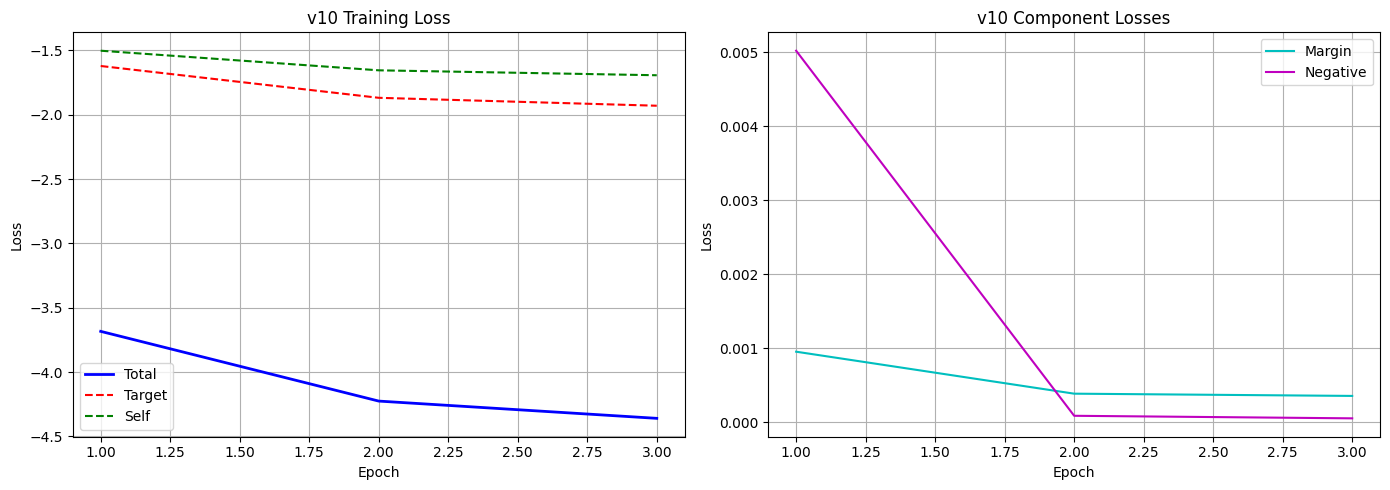

In [16]:
# Plot training curves
if len(history) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    epochs = range(1, len(history) + 1)
    
    axes[0].plot(epochs, [h['total'] for h in history], 'b-', label='Total', linewidth=2)
    axes[0].plot(epochs, [h['target'] for h in history], 'r--', label='Target')
    axes[0].plot(epochs, [h['self'] for h in history], 'g--', label='Self')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('v10 Training Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    axes[1].plot(epochs, [h['margin'] for h in history], 'c-', label='Margin')
    axes[1].plot(epochs, [h['negative'] for h in history], 'm-', label='Negative')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('v10 Component Losses')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig(CONFIG['output_dir'] / 'training_curves.png', dpi=150)
    plt.show()

In [17]:
print("\n" + "=" * 70)
print("v10 TRAINING COMPLETE")
print("=" * 70)
print(f"\nOutput directory: {CONFIG['output_dir']}")
print(f"\nNext step: Run 03_inference_test.ipynb for detailed evaluation")


v10 TRAINING COMPLETE

Output directory: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v10_large_scale

Next step: Run 03_inference_test.ipynb for detailed evaluation
